# Grab carbon boxes

This is likely to require the restarts to work with multi-gas - so needs fair version >= 1.6.3 and < 2.0

## import required packages

In [1]:
import fair
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import scipy.linalg
import json
from tqdm import tqdm
import pickle
from climateforcing.utils import mkdir_p
import matplotlib.pyplot as pl

## check version installed

In [2]:
fair.__version__

'1.6.4'

## get SSP2-4.5 emissions pathways (original CMIP6 version)

In [3]:
ssp_df = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
years = np.arange(1750, 2021)

startyear = 1750
first_scenyear = 2015
last_scenyear = 2020
first_row = int(first_scenyear-startyear)
last_row = int(last_scenyear-startyear)

species = [
    '|CO2|MAGICC Fossil and Industrial',
    '|CO2|MAGICC AFOLU',
    '|CH4',
    '|N2O',
    '|Sulfur',
    '|CO',
    '|VOC',
    '|NOx',
    '|BC',
    '|OC',
    '|NH3',
    '|CF4',
    '|C2F6',
    '|C6F14',
    '|HFC23',
    '|HFC32',
    '|HFC4310mee',
    '|HFC125',
    '|HFC134a',
    '|HFC143a',
    '|HFC227ea',
    '|HFC245fa',
    '|SF6',
    '|CFC11',
    '|CFC12',
    '|CFC113',
    '|CFC114',
    '|CFC115',
    '|CCl4',
    '|CH3CCl3',
    '|HCFC22',
    '|HCFC141b',
    '|HCFC142b',
    '|Halon1211',
    '|Halon1202',
    '|Halon1301',
    '|Halon2402',
    '|CH3Br',
    '|CH3Cl',
]

unit_convert = np.ones(40)
unit_convert[1] = 12/44/1000
unit_convert[2] = 12/44/1000
unit_convert[4] = 28/44/1000
unit_convert[5] = 32/64
unit_convert[8] = 14/46

emissions_out = np.ones((271, 40)) * np.nan
emissions_out[:,0] = years

years_future = [2015, 2020]
for i, specie in enumerate(species):
    emissions_out[:first_row,i+1] = ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable'].str.endswith(specie)),str(startyear):'2014']*unit_convert[i+1]
    f = interp1d(years_future, ssp_df.loc[
        (ssp_df['Model']=='MESSAGE-GLOBIOM')&
        (ssp_df['Region']=='World')&
        (ssp_df['Scenario']=='ssp245')&
        (ssp_df['Variable'].str.endswith(specie)), '2015':'2020'].dropna(axis=1))
    emissions_out[first_row:(last_row+1), i+1] = f(
        np.arange(first_scenyear, last_scenyear+1)
    )*unit_convert[i+1]

In [4]:
emissions_out

array([[1.75000000e+03, 2.59244179e-03, 8.11267109e-02, ...,
        0.00000000e+00, 1.05087730e+02, 4.27574490e+03],
       [1.75100000e+03, 2.59253543e-03, 8.26192087e-02, ...,
        0.00000000e+00, 1.05107200e+02, 4.27676850e+03],
       [1.75200000e+03, 2.59363692e-03, 8.41391642e-02, ...,
        0.00000000e+00, 1.05125020e+02, 4.27770490e+03],
       ...,
       [2.01800000e+03, 1.00055432e+01, 9.17077254e-01, ...,
        3.06640000e-01, 1.33680260e+02, 5.39921664e+03],
       [2.01900000e+03, 1.01011528e+01, 9.03002400e-01, ...,
        2.92820000e-01, 1.33632680e+02, 5.39735322e+03],
       [2.02000000e+03, 1.01967624e+01, 8.88927545e-01, ...,
        2.79000000e-01, 1.33585100e+02, 5.39548980e+03]])

## get FaIR v1.6.2 AR6 config

It's ok to run 1.6.4 with the 1.6.2 config, they are the same model but the slightly later version enables multigas restarts

In [5]:
with open('../data_input/fair-1.6.2/fair-1.6.2-wg3-params.json') as f:
    config_list = json.load(f)

## quick implementation of deterministic two-layer EBM

Uses FaIR 2.0 (Leach et al. 2021) as implemented by Cummins et al. (2020)

In [6]:
tstep = 1

# these are IPCC AR6 central estimates: Smith et al. (2021), chapter 7 SM, AR6, WG1
f2x = 3.93
ohc = [7.7/tstep, 147/tstep]
oht = [1.31, 0.88]  
    # in Cummins notation, the climate feedback parameter is kappa1, and ocean heat transfer is kappa2, ...
eps = 1.03

n_box = 2
eb_matrix = np.zeros((n_box, n_box))

# First row
eb_matrix[0, :2] = [
    -(oht[0]+eps*oht[1])/ohc[0],
    eps*oht[1]/ohc[0],
]

# Last row
eb_matrix[-1, -2:] = [
    oht[-1]/ohc[-1],
    -oht[-1]/ohc[-1]
]

## no stochastic stuff so this is all commented out
#eb_matrix = np.insert(eb_matrix, 0, np.zeros(n_box), axis=0)
#prepend_col = np.zeros(n_box+1)
#prepend_col[0] = -1000  # no forcing autocorrelation
#prepend_col[1] = 1/ohc[0]
#eb_matrix = np.insert(eb_matrix, 0, prepend_col, axis=1)

# Matrix exponential
eb_matrix_d = scipy.linalg.expm(eb_matrix)
eb_matrix_d

forcing_vector = np.zeros(n_box)
forcing_vector[0] = 1/ohc[0]
# forcing_vector[0] = 1000
forcing_vector_d = scipy.linalg.solve(eb_matrix, (eb_matrix_d - np.identity(n_box)) @ forcing_vector)
forcing_vector_d

solution1 = np.zeros((int(150/tstep)+1, n_box))
# solution[0, 0] = 0
for i in range(1, len(solution1)):
    solution1[i, :] = eb_matrix_d @ solution1[i-1, :] + forcing_vector_d * f2x

In [7]:
eb_matrix_d

array([[0.75016935, 0.10197935],
       [0.00518619, 0.99435103]])

In [8]:
forcing_vector_d

array([0.11286358, 0.00035326])

In [9]:
eb_matrix_eigenvalues, eb_matrix_eigenvectors = scipy.linalg.eig(eb_matrix)
timescales = -1/(np.real(eb_matrix_eigenvalues))*tstep
timescales

array([  3.44444534, 285.05902447])

In [10]:
response_coefficients = timescales / tstep * (eb_matrix_eigenvectors[0,:] * scipy.linalg.inv(eb_matrix_eigenvectors)[:,0]) / ohc[0]
response_coefficients

array([0.4434652 , 0.31989358])

In [11]:
# required for running DICE
tstep = 5

# need edit to heat capacities (W m-2 K-1 yr)
f2x = 3.93
ohc = [7.7/tstep, 147/tstep]
oht = [1.31, 0.88]  
    # in Cummins notation, the climate feedback parameter is kappa1, and ocean heat transfer is kappa2, ...
eps = 1.03

eb_matrix = np.zeros((n_box, n_box))

# First row
eb_matrix[0, :2] = [
    -(oht[0]+eps*oht[1])/ohc[0],
    eps*oht[1]/ohc[0],
]

# Last row
eb_matrix[-1, -2:] = [
    oht[-1]/ohc[-1],
    -oht[-1]/ohc[-1]
]

# Matrix exponential
eb_matrix_d = scipy.linalg.expm(eb_matrix)
eb_matrix_d

forcing_vector = np.zeros(n_box)
forcing_vector[0] = 1/ohc[0]
# forcing_vector[0] = 1000
forcing_vector_d = scipy.linalg.solve(eb_matrix, (eb_matrix_d - np.identity(n_box)) @ forcing_vector)
forcing_vector_d

solution5 = np.zeros((int(150/tstep)+1, n_box))
# solution[0, 0] = 0
for i in range(1, len(solution5)):
    solution5[i, :] = eb_matrix_d @ solution5[i-1, :] + forcing_vector_d * f2x

The matrix equation for the EBM is shorthand for:

\begin{equation}
T_1(t+1) = A_{11}T_1(t) + A_{12}T_2(t) + b_1 F(t) \\
T_2(t+1) = A_{21}T_1(t) + A_{21}T_2(t) + b_2 F(t)
\end{equation}

where $A$ is the discretised energy balance matrix, $b$ is the discretised forcing vector, $T_1$ is the mixed layer temperature and $T_2$ the ocean layer temperature.

In [12]:
eb_matrix_d

array([[0.2406594 , 0.30716641],
       [0.01562104, 0.97614564]])

In [13]:
forcing_vector_d

array([0.34517113, 0.00628497])

In [14]:
eb_matrix_eigenvalues, eb_matrix_eigenvectors = scipy.linalg.eig(eb_matrix)
timescales = -1/(np.real(eb_matrix_eigenvalues))*tstep
timescales

array([  3.44444534, 285.05902447])

In [15]:
response_coefficients = timescales / tstep * (eb_matrix_eigenvectors[0,:] * scipy.linalg.inv(eb_matrix_eigenvectors)[:,0]) / ohc[0]
response_coefficients

array([0.4434652 , 0.31989358])

In [16]:
ecs = f2x * np.sum(response_coefficients)
ecs

3.0

In [17]:
DOUBLING_TIME_1PCT = np.log(2)/np.log(1.01)
tcr = f2x * np.sum(
    response_coefficients*(
        1 - timescales/DOUBLING_TIME_1PCT * (
            1 - np.exp(-DOUBLING_TIME_1PCT/timescales)
        )
    )
)
tcr

1.798469224180181

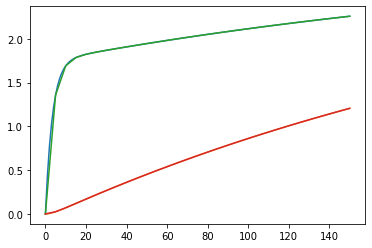

In [18]:
pl.plot(np.arange(0, 151, 1), solution1[:,0])
pl.plot(np.arange(0, 151, 1), solution1[:,1])
pl.plot(np.arange(0, 151, 5), solution5[:,0])
pl.plot(np.arange(0, 151, 5), solution5[:,1])

## define convenience functions for running FaIR

The main differences to here and AR6 are:
- we specify `restart_out=True`
- and we want to truncate the runs at ~2020~ 2015, so we have to chop the natural emissions time series early
- we have to run impulse response rather than energy balance because of restarts (I think)

We then need to run again with the full AR6 setup and get the actual diagnosed temperatures

### convert energy balance to impulse response

See:
- https://github.com/chrisroadmap/ar6/blob/main/notebooks/140_WG3_draw_fair_samples.ipynb
- https://github.com/chrisroadmap/ar6/blob/main/notebooks/200_chapter6_impulse_response_function.ipynb

In [19]:
def _calculate_geoffroy_helper_parameters(
    cmix, cdeep, lambda0, efficacy, eta, f2x
):

    ecs = f2x/lambda0
    tcr = f2x/(lambda0 + efficacy*eta)
    
    b_pt1 = (lambda0 + efficacy * eta) / cmix
    b_pt2 = eta / cdeep
    b = b_pt1 + b_pt2
    b_star = b_pt1 - b_pt2
    delta = b ** 2 - (4 * lambda0 * eta) / (cmix * cdeep)

    taucoeff = cmix * cdeep / (2 * lambda0 * eta)
    d1 = taucoeff * (b - delta ** 0.5)
    d2 = taucoeff * (b + delta ** 0.5)

    phicoeff = cmix / (2 * efficacy * eta)
    phi1 = phicoeff * (b_star - delta ** 0.5)
    phi2 = phicoeff * (b_star + delta ** 0.5)

    qdenom = cmix * (phi2 - phi1)
    q1 = d1 * phi2 / qdenom
    q2 = -d2 * phi1 / qdenom

    out = {
        "d1": d1,
        "d2": d2,
        "q1": q1,
        "q2": q2,
        "ecs": ecs,
        "tcr": tcr,
    }
    return out

In [20]:
def run_fair(args):
    c, f, t, restart_out = fair.forward.fair_scm(**args)
    return (
        c[:,0],
        np.sum(f, axis=1), 
        t-np.mean(t[100:151]),
        restart_out[0][0],
        restart_out[0][1], 
        restart_out[0][2], 
        restart_out[0][3])

def fair_process(emissions):
    updated_config = []
    for i, cfg in enumerate(config_list):
        updated_config.append({})
        for key, value in cfg.items():
            if isinstance(value, list):
                updated_config[i][key] = np.asarray(value)
            else:
                updated_config[i][key] = value
        updated_config[i]['emissions'] = emissions[:266]
        updated_config[i]['diagnostics'] = 'AR6'
        updated_config[i]["efficacy"] = np.ones(45)
        updated_config[i]["gir_carbon_cycle"] = True
        updated_config[i]["temperature_function"] = "Millar"
        updated_config[i]["aerosol_forcing"] = "aerocom+ghan2"
        updated_config[i]["fixPre1850RCP"] = False
        updated_config[i]["restart_out"] = True
        solar_truncated = updated_config[i]["F_solar"][:266]
        updated_config[i]['F_solar'] = solar_truncated
        volcanic_truncated = updated_config[i]["F_volcanic"][:266]
        updated_config[i]['F_volcanic'] = volcanic_truncated
        nat_truncated = updated_config[i]['natural'][:266, :]
        updated_config[i]['natural'] = nat_truncated
        out = _calculate_geoffroy_helper_parameters(
            cfg['ocean_heat_capacity'][0],
            cfg['ocean_heat_capacity'][1],
            cfg['lambda_global'],
            cfg['deep_ocean_efficacy'],
            cfg['ocean_heat_exchange'],
            cfg['F2x']
        )
        updated_config[i]['d'] = np.array([out['d1'], out['d2']])
        updated_config[i]['q'] = np.array([out['q1'], out['q2']])
        
    shape = (266, len(updated_config))
    c_co2 = np.ones(shape) * np.nan
    t = np.ones(shape) * np.nan
    f_tot = np.ones(shape) * np.nan
    cbox = np.ones((4, len(updated_config))) * np.nan
    
    for i, cfg in tqdm(enumerate(updated_config), total=len(updated_config), position=0, leave=True):
        c_co2[:,i], f_tot[:,i], t[:,i], cbox[0,i], cbox[1,i], cbox[2,i], cbox[3,i] = run_fair(updated_config[i])


    return c_co2, f_tot, t, cbox

## Run and print results

In [21]:
results_out = {}
(
    results_out['concentrations'],
    results_out['effective_radiative_forcings'],
    results_out['temperatures'],
    results_out['carbon_boxes']
) = fair_process(emissions_out)

100%|███████████████████████████████████████| 2237/2237 [03:29<00:00, 10.66it/s]


In [22]:
results_out['carbon_boxes'][0,:]

array([60.79646244, 60.79680773, 60.79707325, ..., 60.79548877,
       60.7971741 , 60.79428085])

In [23]:
results_out['carbon_boxes'][1,:]

array([44.54963267, 44.55410384, 45.40955744, ..., 43.78476676,
       44.81162861, 42.40037584])

In [24]:
results_out['carbon_boxes'][2,:]

array([17.55049281, 16.5986711 , 18.93301101, ..., 17.34961367,
       16.53691245, 15.70608604])

In [25]:
results_out['carbon_boxes'][3,:]

array([2.86399779, 2.57284709, 3.21650819, ..., 2.88448037, 2.54560072,
       2.53877829])

In [26]:
print(results_out['carbon_boxes'][0,:].mean(), results_out['carbon_boxes'][0,:].std())

60.79608114016109 0.0015361822430005662


In [27]:
print(results_out['carbon_boxes'][1,:].mean(), results_out['carbon_boxes'][1,:].std())

44.03760835719547 1.47076097051587


In [28]:
print(results_out['carbon_boxes'][2,:].mean(), results_out['carbon_boxes'][2,:].std())

16.641575128193654 1.4766589080060968


In [29]:
print(results_out['carbon_boxes'][3,:].mean(), results_out['carbon_boxes'][3,:].std())

2.653509946114295 0.3467157455750376


In [30]:
results_out

{'concentrations': array([[275.65633583, 276.98880186, 273.94540566, ..., 276.36567192,
         276.1523022 , 279.32820817],
        [275.66817772, 277.00132419, 273.95732615, ..., 276.37684948,
         276.16534091, 279.33916674],
        [275.6922506 , 277.02641789, 273.98152136, ..., 276.39996667,
         276.19126099, 279.36196254],
        ...,
        [394.96724281, 395.33324439, 395.62642108, ..., 394.64090267,
         394.70463255, 394.40765427],
        [397.48121767, 397.74195602, 398.22744965, ..., 397.18816756,
         397.09784616, 396.88517044],
        [400.06642781, 400.21694637, 400.90426367, ..., 399.81038579,
         399.55728686, 399.43479949]]),
 'effective_radiative_forcings': array([[0.2721372 , 0.31034369, 0.27960478, ..., 0.27054144, 0.32778693,
         0.32246421],
        [0.26193777, 0.26699833, 0.23462622, ..., 0.24319164, 0.29304396,
         0.27825703],
        [0.24499493, 0.22287213, 0.19858798, ..., 0.20765912, 0.25305504,
         0.24232657],

(array([ 11.,  83., 274., 531., 640., 408., 199.,  65.,  24.,   2.]),
 array([0.54480157, 0.63783573, 0.73086988, 0.82390404, 0.9169382 ,
        1.00997236, 1.10300651, 1.19604067, 1.28907483, 1.38210899,
        1.47514315]),
 <BarContainer object of 10 artists>)

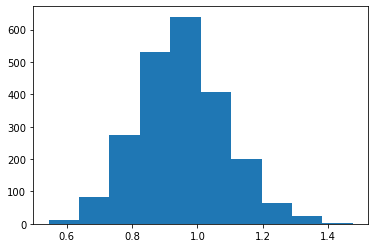

In [31]:
pl.hist(results_out['temperatures'][260:271, :].mean(axis=0))

In [32]:
np.median(results_out['temperatures'][265:266, :].mean(axis=0))

1.0097831444683252

397.25858457032643

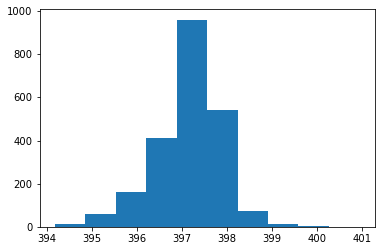

In [33]:
pl.hist(results_out['concentrations'][264]);
np.median(results_out['concentrations'][264])

## Save results as a pickle object

In [34]:
mkdir_p('../data_output/fair-1.6.4/')
with open('../data_output/fair-1.6.4/fair-1.6.4-carbon-boxes.pkl', 'wb') as f:
    pickle.dump(results_out, f)